<a href="https://colab.research.google.com/github/deshanchathusanka/SIDU_XAI_CODE/blob/main/Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ln -s "/content/drive/My Drive/Academic/CSCM 21 - Blessing of Data/coursework/Final Report/SIDU_XAI_CODE/test_images" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM 21 - Blessing of Data/coursework/Final Report/SIDU_XAI_CODE/SIDU_pics" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM 21 - Blessing of Data/coursework/Final Report/SIDU_XAI_CODE/IMAGENET_SIDU_HEATMAPS_single_image_save" "/content/"
!ln -s "/content/drive/My Drive/Academic/CSCM 21 - Blessing of Data/coursework/Final Report/SIDU_XAI_CODE/Evalaute_SIDU_XAI_IMAGENET.pye" "/content/"

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import os
from pathlib import Path
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Activation, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.python.keras.models import load_model
from keras import backend as K
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import cdist
from tensorflow.keras import layers,models

from os.path import join, exists

In [ ]:
def load_image(img_path, input_size, show=False):
    """ to load the image for the own model trained on new dataset """
    img = image.load_img(img_path, target_size=input_size)
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img, img_tensor
  

def load_img(path, input_size):
    """ to load the image for the pretrained model which are trained from imagenet """
    img = image.load_img(path, target_size=input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x


batch_size = 100

def generate_masks_conv_output(input_size, last_conv_output, s= 8):
    """ To generate mask from the last convlutional layers of  CNN model """    
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s) * cell_size

        #grid = np.random.rand(N, s, s) < p1
        #grid = grid.astype('float32')
        #8, 0.5
    grid = np.rollaxis(last_conv_output, 2, 0) 
        
    N = len(grid)
    masks = np.empty((*input_size, N))

    for i in tqdm(range(N), desc='Generating masks'):
                 
        # Linear upsampling and cropping
        #masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
        #                        anti_aliasing=False)
        #[x:x + input_size[0], y:y + input_size[1]]
        """extracting the each feature maps of last convlution layer """
        conv_out = last_conv_output[:,:,i]
        """converting last convlayer to binary mask"""
        conv_out = conv_out > 0.1
        conv_out = conv_out.astype('float32')
        """ upsampling the binary mask using bi-linear interpolation (feature activaions masks) """
        final_resize = resize(conv_out, up_size, order=1, mode='reflect',
                                anti_aliasing=False)
        masks[:, :, i] = final_resize            
#        masks = masks.reshape(-1, *input_size, 1)
    return masks, grid, cell_size, up_size

   
def kernel(d, kernel_width):
    """ computing the exponential weights for the differences"""
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))  

def sim_differences(pred_org, preds):
    """Computing the similarity differences"""
    diff = abs(pred_org-preds)
    weights= kernel(diff,0.25)
    return weights, diff


def normalize(array):
      return (array - array.min()) / (array.max() - array.min() + 1e-13)   
  
def uniqness_measure(masks_predictions):
    """ computing the uniqness between the feature maps """
    #amp_all_cdist =cdist(all_amp_layer_weights, all_amp_layer_weights)
    sum_all_cdist =(cdist(masks_predictions, masks_predictions)).sum(axis=1)
    sum_all_cdist = normalize(sum_all_cdist)
    return sum_all_cdist
def explain_SIDU(model, inp, N, p1, masks, input_size):
    """ SIDU explanation """
    preds = []
    # Make sure multiplication is being done for correct axes
    """ generating the feature image mask for the original image using dot product """
    masked = inp * masks
    """ predicting the score for oringal _input image """
    pred_org = model.predict(inp)
    """ predicting the scores for all feature image masks """
    
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.predict(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    
    weights, diff = sim_differences(pred_org, preds)
    interactions = uniqness_measure(preds)
    new_interactions = interactions.reshape(-1, 1)
    diff_interactions = np.multiply(weights, new_interactions)
    
    sal = diff_interactions.T.dot(masks.reshape(N, -1)).reshape(-1, *input_size)
    sal = sal / N / p1
    return sal, weights, new_interactions, diff_interactions, pred_org

def _show_explanation(img, sal, prediction, input_path, show=True, save=False, save_folder='', alpha=0.3, figsize=(15, 5),
                        cmap=plt.cm.seismic):
    
    """ vizualizing the explanation on original image """
    plt.figure(figsize=figsize)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.axis('off')
    base_name = os.path.basename(input_path)
    title = 'Input ({})'.format(base_name)
    plt.title(title)
    plt.subplot(1, 3, 2)
    h_output = plt.imshow(sal, cmap=cmap)
    plt.axis('off')
    title = 'Output'
    plt.title(title)
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(h_output, cax=cax)
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(sal, cmap='jet', alpha=alpha)
    plt.axis('off')
    #plt.title('Mix')
    plt.title('Explanation for `{}`'.format(class_name(prediction)))
    if save and len(save_folder) > 0:
      save_path = Path(save_folder) / (os.path.splitext(base_name)[0] + '.png')
      plt.savefig(save_path, bbox_inches='tight')
      print('Figure saved to: {}'.format(save_path))
    if show:
      plt.show()

def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

def fold_dir(folder):
    if not os.path.exists(folder):
           os.makedirs(folder)
    return folder

Explaining: 100%|██████████| 21/21 [05:23<00:00, 15.41s/it]


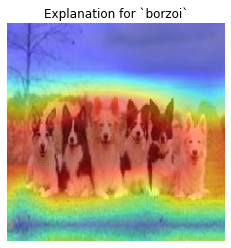

In [ ]:
# if __name__ == '__main__':


## CHOOSING THE base MODEL TO GET EXPLANTIONS
model_eval = 'Resnet50'

### LOADING THE PRE-TRAINED BASE MODEL
### use 
if model_eval == 'Resnet50':
  base_model = ResNet50()
  ####  to see the last layer of CNN use base_model.summary() 
  features_model = Model(inputs=base_model.input, outputs=base_model.get_layer('conv5_block3_out').output)

elif model_eval == 'Vgg19':
  base_model = VGG19(weights='imagenet')
  features_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv4').output)
elif model_eval == 'Vgg16':
  base_model = VGG16(weights='imagenet')
  features_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)




## reading the image from  the folder
# read_path = join('test_images', 'water-bird.JPEG')
read_path = join('test_images', 'multiple_dogs.jpg')

### load the image

img, x = load_img(read_path, (224,224))

### extract the last convlution layers feature activation maps of the model
feature_activation_maps = features_model.predict(x)

last_conv_output = np.squeeze(feature_activation_maps)


    
masks, grid, cell_size, up_size = generate_masks_conv_output((224,224), last_conv_output, s= 8)
## TO DISPLAY THE FEATURE ACTIVATION IMAGE MASKS
mask_ind = masks[:, :, 500]
grid_ind = grid[500,:,:]
new_mask= np.reshape(mask_ind,(224,224))
new_masks = np.rollaxis(masks, 2, 0)
size = new_masks.shape
data = new_masks.reshape(size[0], size[1], size[2], 1)
masked = x * data
#     plt.subplot(1, 3, 2)
#     plt.imshow(new_mask)
#     plt.subplot(1, 3, 1)
#     plt.imshow(grid_ind)
#     plt.subplot(1, 3, 3)
#     plt.imshow(masked[500,:,:])
N = len(new_masks)

### Visual explnations for the object class  
sal, weights, new_interactions, diff_interactions, pred_org = explain_SIDU(base_model, x, N, 0.5, data, (224,224))

## getting the top predicted class
pred_vec= base_model.predict(x)
pred = np.argmax(pred_vec)
class_idx = pred
    
    
#     plt.figure()
#     _show_explanation(img, sal[class_idx], class_idx,  read_path+'imagenet', show=True, save=True, save_folder='', alpha=0.3, figsize=(15, 5),
#                        cmap='jet')
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal[class_idx], cmap='jet', alpha=0.5)
plt.axis('off') 
# plt.colorbar()
plt.show()